## 7.1 数据处理

先载入一些必备的包：

In [20]:
import zipfile  # 处理压缩文件
import os

import pandas as pd  # 处理 csv 文件
import numpy as np
from matplotlib import pyplot as plt

# ----- 自定义模块
from utils.zipimage import ImageZ
%matplotlib inline

查看 https://www.kaggle.com/c/dogs-vs-cats/data 下数据的基本信息。从该网址可以知道：训练数据 `tain.zip` 包括 $50\,000$ 个样本，其中猫和狗各半。而其任务是预测 `test1.zip` 的标签（$1 = dog, 0 = cat$）。为了方便将数据下载到本地，然后做如下操作：

为了以后方便处理其他的 Kaggle 提供的数据，将 `unzip` 函数封装到了 kaggle 包下的 helper 模块中。`unzip` 实现的功能是将 `root` 下的 `'all.zip'` 文件解压并返回解压后数据所在的目录，同时也将 `'all.zip'` 删除（之后用不到了）。

先看看 `dataDir` 目录下面都是什么文件？

In [2]:
dataDir = 'data/dog_cat'
os.listdir(dataDir)

['sampleSubmission.csv', 'test1.zip', 'train.zip']

文件 `'sampleSubmission.csv'` 是 kaggle 比赛提交预测结果的样式：

In [3]:
submit = pd.read_csv(os.path.join(dataDir, 'sampleSubmission.csv'))
submit.head()

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


其中 `id` 表示 `test.zip` 中图片的文件名称，比如 `id = 1` 代表图片文件名为 `1.jpg`。`label` 表示图片的标签（1=dog,0=cat）。训练集和测试集都是 `.zip` 压缩文件，下面直接利用类 ImageZ 来读取数据：

In [4]:
testset = ImageZ(dataDir, 'test1') # 测试数据
trainZ = ImageZ(dataDir, 'train') # 训练数据

你也许会疑惑，训练数据的标签呢？其实，在 https://www.kaggle.com/c/dogs-vs-cats/data 中你查看 `train.zip` 便可以发现其类别信息隐藏在文件名中，为此，可以直接查看 trainZ 的 `names` 属性：

In [5]:
trainZ.names[:5]  # 查看其中的 5 个文件名

['train/cat.0.jpg',
 'train/cat.1.jpg',
 'train/cat.10.jpg',
 'train/cat.100.jpg',
 'train/cat.1000.jpg']

因而，对于训练数据可以通过文件名来获知其所属于的类别。为了与 `1=dog,0=cat` 对应，下面定义：

In [6]:
class_names = ('cat', 'dog')
class_names[1], class_names[0]

('dog', 'cat')

为了后期处理方便，定义 DataSet 类：

In [7]:
class DataSet(ImageZ):
    def __init__(self, dataDir, dataType):
        super().__init__(dataDir, dataType)
        self.class_names = ('cat', 'dog')  # 数据集的类名称
        self._get_name_class_dict()

    def _get_name_class_dict(self):
        self.name_class_dict = {}  # 通过文件名获取图片的类别
        class_dict = {
            class_name: i
            for i, class_name in enumerate(self.class_names)
        }
        for name in self.names:
            class_name = name.split('.')[0].split('/')[-1]
            self.name_class_dict[name] = class_dict[class_name]
            
    def __iter__(self):
        for name in self.names:
            # 返回 (data, label) 数据形式
            yield self.buffer2array(name), self.name_class_dict[name]

下面看看如何使用 DataSet 类：

大小： (374, 500, 3) 标签： 0


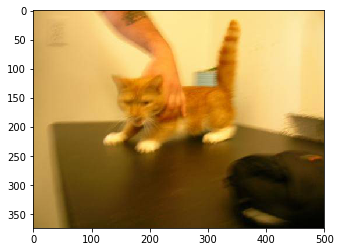

In [8]:
dataset = DataSet(dataDir, 'train')

for img, label in dataset:
    print("大小：",img.shape, '标签：', label)  # 查看一张图片
    plt.imshow(img)
    plt.show()
    break

为了查看模型的泛化性，需要将 dataset 划分为 trainset 与 valset，为此需要将 dataset 的 names 属性进行划分。由于 dataset 的特殊性，下面对 trainZ 进行处理比较好：

In [9]:
cat_rec = []
dog_rec = []
for name in trainZ.names:
    if name.startswith('train/cat'):
        cat_rec.append((name, 0))
    elif name.startswith('train/dog'):
        dog_rec.append((name, 1))

为了避免模型依赖于数据集的顺序，下面将会打乱原数据集的顺序：

In [10]:
import random
random.shuffle(cat_rec)  # 打乱 cat_names
random.shuffle(dog_rec)  # 打乱 dog_names

train_rec = cat_rec[:10000] + dog_rec[:10000]  # 各取其中的 10000 个样本作为训练
val_rec = cat_rec[10000:] + dog_rec[10000:]  # 剩余的作为测试
random.shuffle(train_rec)   # 打乱类别的分布，提高模型的泛化能力
random.shuffle(val_rec)
len(train_rec), len(val_rec)

(20000, 5000)

从上面的代码我们可以知道，训练数据和验证数据的样本个数分别为：20000 和 5000。下面为了可以让模型能够使用该数据集，需要定义一个**生成器**：

In [11]:
class Loader(ImageZ):
    def __init__(self, imgZ, rec, shuffle=False, target_size=None):
        if shuffle:
            random.shuffle(rec)  # 训练集需要打乱
        self.shuffle = shuffle
        self.imgZ = imgZ
        self.rec = rec
        self.__target_size = target_size
        
    def name2array(self, name):
        # 将 name 转换为 array
        import cv2
        img = self.imgZ.buffer2array(name)
        if self.__target_size:   # 将图片 resize 为 self.target_size
            return cv2.resize(img, self.__target_size)
        else:
            return img

    def __getitem__(self, item):
        rec = self.rec[item]
        if isinstance(item, slice):
            return [(self.name2array(name), label) for (name, label) in rec]
        else:
            return self.name2array(rec[0]), rec[1]

    def __iter__(self):
        for name, label in self.rec:
            yield self.name2array(name), label  # 返回 (data, label)

    def __len__(self):
        return len(self.rec)  # 返回数据样本数

这样，便可以得到随机划分后的 `trainset` 和 `valset`。

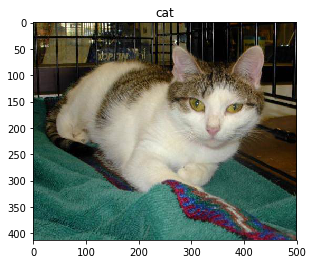

In [12]:
trainset = Loader(trainZ, train_rec, True)  # 训练集
valset = Loader(trainZ, val_rec)  # 验证集

for img, label in trainset:
    plt.imshow(img)    # 显示出图片
    plt.title(str(class_names[label]))  # 将类别作为标题
    plt.show()
    break

数据处理好之后，看看图片的大小：

In [13]:
name2size = {}   # 获得图片的 size
for name in trainZ.names:
    name2size[name] = trainZ.buffer2array(name).shape[:-1]
min({w for h, w in set(name2size.values())}), min({h for h, w in set(name2size.values())})

(42, 32)

从上述代码可以看出：图片的最小高和宽分别为 32 和 42，基于此，不妨将所有的图片均 resize 为 `(150, 150)`。

## 7.2 Gluon 实现模型的训练和预测

Gluon 的学习可以参考李沐大神的 [《动手学深度学习》](http://zh.d2l.ai/)：http://zh.d2l.ai/ 。为了提高模型的泛化能力，数据增强技术是十分有必要的，Gluon 提供了一个十分方便的模块 `transforms`，下面我们来看看它的具体使用：

In [14]:
from mxnet.gluon.data.vision import transforms as gtf

transform_train = gtf.Compose([
    # 随机对图像裁剪出面积为原图像面积0.08~1倍、且高和宽之比在3/4~4/3的图像，再放缩为高和
    # 宽都是为 150 的新图
    gtf.RandomResizedCrop(
        150, scale=(0.08, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    gtf.RandomFlipLeftRight(),
    # 随机变化亮度、对比度和饱和度
    gtf.RandomColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
    # 随机加噪声
    gtf.RandomLighting(0.1),
    gtf.ToTensor(),
    # 对图像的每个通道做标准化
    gtf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

transform_test = gtf.Compose([
    gtf.Resize(256),
    # 将图像中央的高和宽均为 150 的正方形区域裁剪出来
    gtf.CenterCrop(150),
    gtf.ToTensor(),
    gtf.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


由于 Gluon 的数据输入是 `mxnet.ndarray.ndarray.NDArray` 类型的数据，而 Loader 类的输出是 `numpy.ndarray` 类型的数据，因而，需要改写 `Loader` 类。

In [15]:
from mxnet import nd
from mxnet.gluon import data as gdata

class GluonLoader(Loader, gdata.Dataset):  #  gdata.Dataset 是 gluon 处理数据的基类之一
    def __init__(self, imgZ, rec):
        super().__init__(imgZ, rec)
        
    def name2array(self, name):
        return nd.array(self.imgZ.buffer2array(name)) # 将 name 转换为 array

下面可以看看 GluonLoader 类实现了哪些有趣的功能？

In [16]:
train_ds = GluonLoader(trainZ, train_rec)
valid_ds = GluonLoader(trainZ, val_rec)

for img, label in train_ds:
    print(type(img), img.shape, label)
    break

<class 'mxnet.ndarray.ndarray.NDArray'> (413, 500, 3) 0


此时，`img` 已经满足 Gluon 所创建的模型的输入数据要求。对于图像分类任务，卷积神经网络无疑是一个比较好的模型。对于卷积神经网络来说，一般会采用 第 2 章介绍的 小批量随机梯度下降优化策略来训练模型。我们需要将数据转换为批量形式，而 gluon.data.DataLoader 为我们实现该功能提供了便利：

In [17]:
from mxnet.gluon import data as gdata
batch_size = 16  # 批量大小

train_iter = gdata.DataLoader(      # 每次读取一个样本数为 batch_size 的小批量数据
    train_ds.transform_first(transform_train),  # 变换应用在每个数据样本（图像和标签）的第一个元素，即图像之上
    batch_size,
    shuffle=True,                # 训练数据需要打乱
    last_batch='keep')             # 保留最后一个批量
valid_iter = gdata.DataLoader(
    valid_ds.transform_first(transform_test),
    batch_size,
    shuffle=True,           # 验证数据需要打乱
    last_batch='keep')

`train_ds.transform_first(transform_train)` 和 `valid_ds.transform_first(transform_test)` 均将原数据集应用了数据增强技术，并将其转换为了适合 Gluon 所创建卷积神经网络的输入形式。

### 7.2.1 建立并训练模型

在建立本章所需要的模型之前，先了解一些卷积神经网络的必备知识。卷积神经网络简单的说就是含有卷积层的神经网络。神经网络就是具有层级结构的神经元组成的具有提取数据的多级特征的机器学习模型。一个神经元由仿射变换（矩阵运算）+非线性变换（被称为激活函数）组成。在 Gluon 中卷积运算由 `nn.Conv2D` 来实现（具体细节见 http://zh.d2l.ai/chapter_convolutional-neural-networks/conv-layer.html ）。

二维卷积层输出的数组可以看作是数据在宽和高维度上某一级的特征表示（也叫**特征图**（feature map）或表征）或是对输入的响应（称作**响应图**（response map））。

In [18]:
# 载入一些必备包
from mxnet import autograd, init, gluon
from mxnet.gluon import model_zoo
import d2lzh as d2l
from mxnet.gluon import loss as gloss, nn
from gluoncv.utils import TrainingHistory  # 可视化
from mxnet import metric   # 计算度量的模块

`nn.Conv2D` 常用参数：

- `channels`：下一层特征图的**通道数**，即卷积核的个数
- `kernel_size`：卷积核的尺寸
- `activation`：**激活函数**

还有一点需要注意：卷积层的输出可由下面的公式来计算：

$$
\begin{cases}
h_{out} = \lfloor \frac{h_{in} - f_h + 2p}{s} \rfloor + 1 \\
w_{out} = \lfloor \frac{w_{in} - f_w + 2p}{s} \rfloor + 1
\end{cases}
$$

- $h_{out}, w_{out}$ 表示卷积层的输出的特征图尺寸
- $h_{in}, w_{in}$ 表示卷积层的输入的特征图尺寸
- $f_h, f_w$ 表示卷积核的尺寸，即 `nn.Conv2D` 的参数 `kernel_size`
- $s$ 表示卷积核移动的步长，即 `nn.Conv2D` 的参数 `strides`
- $p$ 表示卷积层的输入的填充大小，即 `nn.Conv2D` 的参数 `padding`，减小边界效应带来的影响

虽然，使用步进卷积（strides 大于 1）可以对图像进行下采样，但是，一般很少使用它。一般地，可以使用**池化**操作来实现下采样。在 Gluon 中使用 `nn.MaxPool2D` 和 `nn.AvgPool2D` 实现。

下面创建模型并训练：

epoch 0, train loss 0.65795, valid loss 0.62077, train acc 0.60655, valid acc 0.66460, time 235.13 sec
epoch 1, train loss 0.62687, valid loss 0.67691, train acc 0.64355, valid acc 0.60360, time 188.91 sec
epoch 2, train loss 0.60665, valid loss 0.60128, train acc 0.66330, valid acc 0.66800, time 172.01 sec
epoch 3, train loss 0.59334, valid loss 0.72213, train acc 0.67495, valid acc 0.60420, time 256.09 sec
epoch 4, train loss 0.58238, valid loss 0.56841, train acc 0.68755, valid acc 0.69320, time 203.10 sec
epoch 5, train loss 0.57717, valid loss 0.53318, train acc 0.68920, valid acc 0.73640, time 168.64 sec
epoch 6, train loss 0.56650, valid loss 0.48666, train acc 0.70280, valid acc 0.77720, time 165.77 sec
epoch 7, train loss 0.55835, valid loss 0.51535, train acc 0.71085, valid acc 0.74740, time 162.70 sec
epoch 8, train loss 0.55538, valid loss 0.48698, train acc 0.70710, valid acc 0.77060, time 161.31 sec
epoch 9, train loss 0.54723, valid loss 0.52794, train acc 0.71390, valid

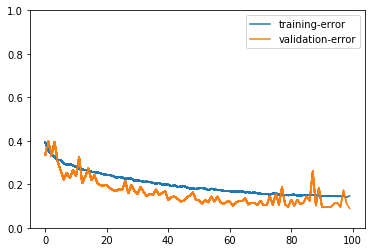

In [19]:
def get_net(ctx):
    # 创建模型
    model = nn.HybridSequential()
    model.add(
        nn.BatchNorm(), nn.Activation('relu'),   # 批量归一化
        nn.MaxPool2D((2, 2)),                 # 最大池化
        nn.Conv2D(32, (3, 3)),              # 32 个卷积核尺寸为 (3，3)
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D((2, 2)),                 # 最大池化
        nn.Conv2D(64, (3, 3)),              # 64 个卷积核尺寸为 (3，3)
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D((2, 2)),                 # 最大池化
        nn.Conv2D(128, (3, 3)),              # 128 个卷积核尺寸为 (3，3)
        nn.BatchNorm(), nn.Activation('relu'),
        nn.MaxPool2D((2, 2)),                 # 最大池化
        nn.Conv2D(512, kernel_size=1),  # 1 x 1 卷积 进行降维
        nn.BatchNorm(), nn.Activation('relu'),
        nn.GlobalAvgPool2D(),             # 全局平均池化
        nn.Dense(2)       # 输出层

    )
    model.initialize(init.Xavier(), ctx=ctx)      # 模型初始化
    return model


def evaluate_loss(data_iter, net, ctx):
    l_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.as_in_context(ctx).astype('float32')  # 模型的输出是 float32 类型数据
        outputs = net(X.as_in_context(ctx))  # 模型的输出
        l_sum += loss(outputs, y).sum().asscalar()  # 计算总损失
        n += y.size  # 计算样本数
    return l_sum / n   # 计算平均损失


def test(valid_iter, net, ctx):
    val_metric = metric.Accuracy()
    for X, y in valid_iter:
        X = X.as_in_context(ctx)
        y = y.as_in_context(ctx).astype('float32')  # 模型的输出是 float32 类型数据
        outputs = net(X)
        val_metric.update(y, outputs)
    return val_metric.get()


def train(net, train_iter, valid_iter, num_epochs, lr, wd, ctx, model_name):
    import time
    trainer = gluon.Trainer(net.collect_params(), 'rmsprop', {
                            'learning_rate': lr, 'wd': wd})  # 优化策略
    train_metric = metric.Accuracy()
    train_history = TrainingHistory(['training-error', 'validation-error'])
    best_val_score = 0
    for epoch in range(num_epochs):
        train_l_sum, n, start = 0.0, 0, time.time()  # 计时开始
        train_acc_sum = 0
        train_metric.reset()
        for X, y in train_iter:
            X = X.as_in_context(ctx)
            y = y.as_in_context(ctx).astype('float32')  # 模型的输出是 float32 类型数据
            with autograd.record():  # 记录梯度信息
                outputs = net(X)     # 模型输出
                l = loss(outputs, y).sum()  # 计算总损失
            l.backward()                   # 反向传播
            trainer.step(batch_size)
            train_l_sum += l.asscalar()  # 计算该批量的总损失
            train_metric.update(y, outputs)   # 计算训练精度
            n += y.size
        _, train_acc = train_metric.get()
        time_s = "time {:.2f} sec".format(time.time() - start)  # 计时结束
        valid_loss = evaluate_loss(valid_iter, net, ctx)   # 计算验证集的平均损失
        _, val_acc = test(valid_iter, net, ctx)  # 计算验证集的精度
        epoch_s = ("epoch {:d}, train loss {:.5f}, valid loss {:.5f}, train acc {:.5f}, valid acc {:.5f}, ".format(
            epoch, train_l_sum / n, valid_loss, train_acc, val_acc))
        print(epoch_s + time_s)
        train_history.update([1-train_acc, 1-val_acc])  # 更新图像的纵轴
        train_history.plot(
            save_path='{}/{}_history.png'.format('images', model_name))  # 实时更新图像
        if val_acc > best_val_score:  # 保存比较好的模型
            best_val_score = val_acc
            net.save_parameters(
                '{}/{:.4f}-{}-{:d}-best.params'.format('models', best_val_score, model_name, epoch))


loss = gloss.SoftmaxCrossEntropyLoss()  # 交叉熵损失函数
ctx, num_epochs, lr, wd = d2l.try_gpu(), 100, 1e-4, 1e-5
net = get_net(ctx)   # 在 ctx 上训练
net.hybridize()   # 转换为符号式编程
train(net, train_iter, valid_iter, num_epochs, lr, wd, ctx, 'dog_cat')

上面创建的模型是依据 VGG 结构进行改写的，同时为了加快模型训练加入了 `nn.BatchNorm`，即**批量归一化**。

In [21]:
net

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=3)
  (1): Activation(relu)
  (2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (3): Conv2D(3 -> 32, kernel_size=(3, 3), stride=(1, 1))
  (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=32)
  (5): Activation(relu)
  (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (7): Conv2D(32 -> 64, kernel_size=(3, 3), stride=(1, 1))
  (8): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (9): Activation(relu)
  (10): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  (11): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1))
  (12): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=128)
  (13): Activation(relu)
  (14): MaxPool2D(size=(2, 2), stride=(2, 2